In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import sys
from time import time
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
## performance metrics for classification
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix,ConfusionMatrixDisplay,classification_report,plot_confusion_matrix

In [2]:
df = pd.read_csv("cleaned_reviews.csv")
df.head(3)

,Condition,review_text
0,Birth Control,havent gotten pregnant job switched brand another generic get nauseous generally feel tired also headache
1,Birth Control,taking lyza made break horribly tried month bad stopped taking itas inceedible much damaged skin month itas month since stopped taking skin way better still acne really bad scar definitely would take besides acne taking lyza started get period anymore starting month everything else fine didnat give mood swing anything like
2,Birth Control,stuff need removed market harmful age fast dark racoon eye dark mark neck shortness breath horrible mood swing horrible acne enlarged poor hair loss avoid birth control literally plague


In [3]:
df.isnull().sum()

Condition      0
review_text    0
dtype: int64

In [4]:
#df.drop(columns=['Drug','Reviews','Effectiveness','Satisfaction'],inplace=True)
df.dropna(inplace=True)
df.shape

(50360, 2)

In [5]:
df.Condition.value_counts()

High Blood Pressure         19377
Depression                  12686
Birth Control               11940
Type 2 Diabetes Mellitus     6357
Name: Condition, dtype: int64

In [6]:
zero_class = 50360/(4*11940) # Birth Control
print(zero_class)
first_class = 50360/(4*12686) # Depression
print(first_class)
second_class = 50360/(4*19377) # High Blood Pressure
print(second_class)
third_class = 50360/(4*6357) # Type 2 Diabetes Mellitus
print(third_class)

class_weights = {0:zero_class,1:first_class,2:second_class,3:third_class}
class_weights

1.0544388609715243
0.9924326028693048
0.6497393817412396
1.9804939436841278


{0: 1.0544388609715243,
 1: 0.9924326028693048,
 2: 0.6497393817412396,
 3: 1.9804939436841278}

### Storing dependent and independent columns separately

In [7]:
le = LabelEncoder()
Y = le.fit_transform( df['Condition'])
Y = np.array(Y)
Y

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
le.inverse_transform([0,1,2,3])

array(['Birth Control', 'Depression', 'High Blood Pressure',
       'Type 2 Diabetes Mellitus'], dtype=object)

In [9]:



Y = df['Condition']
X = df.drop(columns='Condition')

In [10]:
X.head(50)

,review_text
0,havent gotten pregnant job switched brand another generic get nauseous generally feel tired also headache
1,taking lyza made break horribly tried month bad stopped taking itas inceedible much damaged skin month itas month since stopped taking skin way better still acne really bad scar definitely would take besides acne taking lyza started get period anymore starting month everything else fine didnat give mood swing anything like
2,stuff need removed market harmful age fast dark racoon eye dark mark neck shortness breath horrible mood swing horrible acne enlarged poor hair loss avoid birth control literally plague
3,usually zero little acne month taking medication made breakout horribly place around mouth chin forehead cystic acne bad horrible mood swing pill wasnt trying new birth control
4,concerned starting pill due high found mini pill estrogen despite negative review absolutely love lyza couple month stopped getting period period every month spotting period either way like getting period thatas plus pill side effect thing must take pill time day
5,birth control easy use worked side effect great started lose hair like alot ended two bald patch left side head pretty bad embarrassing stopped taking hair started grow back normal iall mostly never take birth control hope research taking new birth control
6,lyza birth control worst birth control pill ever taken ive taking couple week feel like crazy person ive cry reason super depressed anxiety terrible along daily headache break out realize everyones body reacts differently medication ive read nothing negative review surely attest wouldnt advise anyone take absolutely awful
7,iave taking lyza year absolutely hate caused slight weight gain acne esp chest period every two week headache mood swing control iave gotten depressed anxious angry time due glad read review seeing psych idea depressed angry time fun besides iam stuck raise risk stroke due fact smoke pure crap may try stay see anything change
8,taking lyza two month anxious going back pill iud past several year noticed acne never nothing extreme eat healthy exercise three time week havent noticed water weight bloating mild acne pretty happy
9,pill little two month experience horrible dont know anymore get period always spotting sometimes light day get four day heavy bleeding go back spotting light three day non stop crazy changing another type birth control


In [11]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 stratify=Y,
                                                 test_size=0.20,
                                                 random_state=1)

In [12]:
x_train.head(3)

,review_text
32923,altace seems work along medslipitor coreg benecar norvasc lasixand aspirin
29021,pill yr work good lowering notice sexual side effect run exsersice regularly increase water intake dramatically order avoid strong leg cramp dosage half pill
1525,havve borderline high blood pressure experienced negative effect lisenopril heard cough possible develop thankfully occur noticed cause drowiness though take night


## Vectorization using countvectorizer and tfidf vectorizer

In [13]:
# creating bag of words using count vectorizer
t0 = time()
count_vectorizer = CountVectorizer(stop_words='english',
                                   max_df=0.85,   # When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
                                   max_features=20000)
count_vectorizer.fit(x_train.review_text)

# transform the training and testing data using count vectorizer object
count_train =  count_vectorizer.transform(x_train.review_text)
count_test =  count_vectorizer.transform(x_test.review_text)
dur = time() - t0
print("Time taken for feature extraction: ",dur,"s","\n")

# x_train_count = pd.concat([x_train[['Effectiveness', 'Satisfaction']].reset_index(drop=True),
#                          pd.DataFrame(count_train.toarray())],
#                          axis=1)
# x_test_count = pd.concat([x_test[['Effectiveness', 'Satisfaction']].reset_index(drop=True),
#                          pd.DataFrame(count_test.toarray())],
#                          axis=1)

Time taken for feature extraction:  1.9515674114227295 s 



In [14]:
print(f"Length of vocabulary dictionary created by BoW model : {len(count_vectorizer.vocabulary_)}")

Length of vocabulary dictionary created by BoW model : 20000


In [15]:
count_vectorizer.vocabulary_

{'altace': 871,
 'work': 19318,
 'coreg': 3857,
 'benecar': 2374,
 'norvasc': 10366,
 'aspirin': 1468,
 'pill': 11339,
 'yr': 19799,
 'good': 6899,
 'lowering': 9086,
 'notice': 10392,
 'sexual': 15166,
 'effect': 5434,
 'run': 14459,
 'regularly': 13613,
 'increase': 7909,
 'water': 18924,
 'intake': 8122,
 'dramatically': 5143,
 'order': 10702,
 'avoid': 1800,
 'strong': 16034,
 'leg': 8674,
 'cramp': 3985,
 'dosage': 5070,
 'half': 7098,
 'havve': 7209,
 'borderline': 2647,
 'high': 7405,
 'blood': 2572,
 'pressure': 12182,
 'experienced': 5983,
 'negative': 10155,
 'lisenopril': 8874,
 'heard': 7306,
 'cough': 3882,
 'possible': 11753,
 'develop': 4556,
 'thankfully': 16630,
 'occur': 10534,
 'noticed': 10396,
 'cause': 3063,
 'drowiness': 5228,
 'night': 10227,
 'ended': 5619,
 'hospital': 7543,
 'sugar': 16135,
 'severly': 15157,
 'dehydrated': 4369,
 'sick': 15288,
 'day': 4223,
 'doctor': 5033,
 'insulin': 8109,
 'actos': 230,
 'week': 18976,
 'gained': 6688,
 'pound': 11835,
 

In [16]:
corpus = ['losing lb last two year gained back two week changing lyza ortho top feel constantly bloated',
          'hair started falling bad acne even though ive never really acne']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
X.toarray()

['acne', 'back', 'bad', 'bloated', 'changing', 'constantly', 'even', 'falling', 'feel', 'gained', 'hair', 'ive', 'last', 'lb', 'losing', 'lyza', 'never', 'ortho', 'really', 'started', 'though', 'top', 'two', 'week', 'year']


array([[0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        2, 1, 1],
       [2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0]], dtype=int64)

In [17]:
pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names()).head(3)

,acne,back,bad,bloated,changing,constantly,even,falling,feel,gained,hair,ive,last,lb,losing,lyza,never,ortho,really,started,though,top,two,week,year
0,0,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,0,0,1,2,1,1
1,2,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,1,0,0,0,0


In [18]:
# ngram level tf-idf 
t0 = time()
tfidf_vect_ngram = TfidfVectorizer(stop_words='english',
                                   max_df=0.85,
                                   max_features=20000,
                                   ngram_range=(1,2))
tfidf_vect_ngram.fit(x_train.review_text)

# transform the training and testing data using tfidf vectorizer object
tfidf_train_ngram =  tfidf_vect_ngram.transform(x_train.review_text)
tfidf_test_ngram =   tfidf_vect_ngram.transform(x_test.review_text)
dur = time() - t0
print("Time taken for feature extraction: ",dur,"s","\n")
# x_train_tfidf_ngram = pd.concat([x_train[['Effectiveness', 'Satisfaction']].reset_index(drop=True),
#                          pd.DataFrame(tfidf_train_ngram.toarray())],
#                          axis=1)
# x_test_tfidf_ngram = pd.concat([x_test[['Effectiveness', 'Satisfaction']].reset_index(drop=True),
#                          pd.DataFrame(tfidf_test_ngram.toarray())],
#                          axis=1)

Time taken for feature extraction:  4.608816862106323 s 



In [19]:
corpus = ['losing lb last two year gained back two week changing lyza ortho top feel constantly bloated',
          'hair started falling bad acne even though ive never really acne']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
X.toarray()

['acne', 'back', 'bad', 'bloated', 'changing', 'constantly', 'even', 'falling', 'feel', 'gained', 'hair', 'ive', 'last', 'lb', 'losing', 'lyza', 'never', 'ortho', 'really', 'started', 'though', 'top', 'two', 'week', 'year']


array([[0.        , 0.23570226, 0.        , 0.23570226, 0.23570226,
        0.23570226, 0.        , 0.        , 0.23570226, 0.23570226,
        0.        , 0.        , 0.23570226, 0.23570226, 0.23570226,
        0.23570226, 0.        , 0.23570226, 0.        , 0.        ,
        0.        , 0.23570226, 0.47140452, 0.23570226, 0.23570226],
       [0.5547002 , 0.        , 0.2773501 , 0.        , 0.        ,
        0.        , 0.2773501 , 0.2773501 , 0.        , 0.        ,
        0.2773501 , 0.2773501 , 0.        , 0.        , 0.        ,
        0.        , 0.2773501 , 0.        , 0.2773501 , 0.2773501 ,
        0.2773501 , 0.        , 0.        , 0.        , 0.        ]])

In [20]:
pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

,acne,back,bad,bloated,changing,constantly,even,falling,feel,gained,hair,ive,last,lb,losing,lyza,never,ortho,really,started,though,top,two,week,year
0,0.0000,0.235702,0.00000,0.235702,0.235702,0.235702,0.00000,0.00000,0.235702,0.235702,0.00000,0.00000,0.235702,0.235702,0.235702,0.235702,0.00000,0.235702,0.00000,0.00000,0.00000,0.235702,0.471405,0.235702,0.235702
1,0.5547,0.000000,0.27735,0.000000,0.000000,0.000000,0.27735,0.27735,0.000000,0.000000,0.27735,0.27735,0.000000,0.000000,0.000000,0.000000,0.27735,0.000000,0.27735,0.27735,0.27735,0.000000,0.000000,0.000000,0.000000


# Naive Bayes Classifier

Time taken for training Naive Bayes model on N_gram tf-idf vectors 6.1043617725372314 seconds
Mean accuracy using MultinomialNB:  0.8794430009358948
Test accuracy : 0.8836378077839555

Confusion Matrix: 
 [[2275   40   66    7]
 [  68 2248  206   15]
 [  88  256 3460   71]
 [  30   69  256  917]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      2388
           1       0.86      0.89      0.87      2537
           2       0.87      0.89      0.88      3875
           3       0.91      0.72      0.80      1272

    accuracy                           0.88     10072
   macro avg       0.89      0.86      0.87     10072
weighted avg       0.88      0.88      0.88     10072



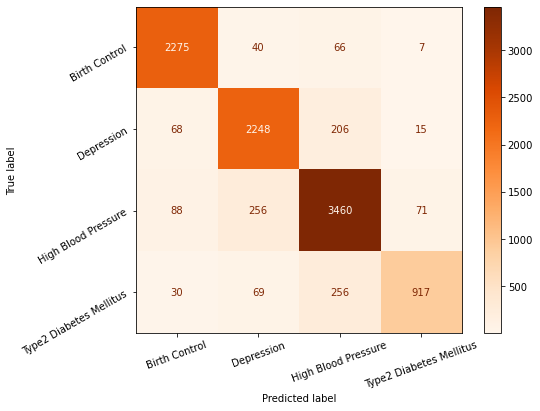

In [21]:
# Training Naive Bayes using count Vectors

NB = MultinomialNB()
k_fold = StratifiedKFold(n_splits=3)
NB_scores = cross_val_score(NB, count_train, y_train,cv=k_fold,n_jobs=-1)
print("Time taken for training Naive Bayes model on N_gram tf-idf vectors",time()-t0,"seconds")
print("Mean accuracy using MultinomialNB: ", np.mean(NB_scores))
NB.fit(count_train,y_train)
print("Test accuracy :", accuracy_score(y_test,NB.predict(count_test)))

print()
y_predicted = NB.predict(count_test)
cm = confusion_matrix(y_test, y_predicted)

print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Oranges',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

Time taken for training Naive Bayes model on tfidf vectors 1.002213478088379 seconds
Mean accuracy using MultinomialNB:  0.8630112986233677
Test accuracy : 0.8836378077839555

Confusion Matrix: 
 [[2275   40   66    7]
 [  68 2248  206   15]
 [  88  256 3460   71]
 [  30   69  256  917]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      2388
           1       0.86      0.89      0.87      2537
           2       0.87      0.89      0.88      3875
           3       0.91      0.72      0.80      1272

    accuracy                           0.88     10072
   macro avg       0.89      0.86      0.87     10072
weighted avg       0.88      0.88      0.88     10072



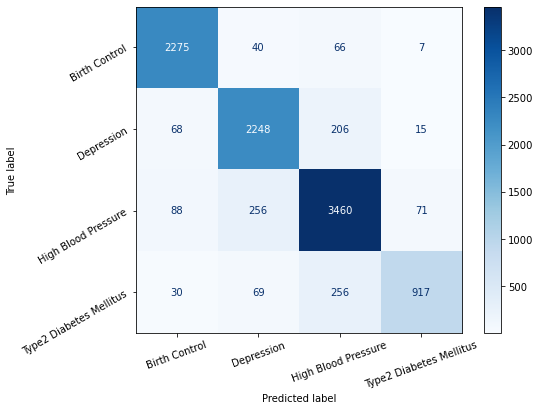

In [22]:
# Training Naive Bayes using N-gram TF-IDF Vectors
NB_tfidf = MultinomialNB()
t0 = time()
NB_scores = cross_val_score(NB_tfidf, tfidf_train_ngram, y_train,cv=k_fold,n_jobs=-1)
duration = time()-t0
print("Time taken for training Naive Bayes model on tfidf vectors",duration,"seconds")
print("Mean accuracy using MultinomialNB: ", np.mean(NB_scores))
NB_tfidf.fit(count_train,y_train)
print("Test accuracy :", accuracy_score(y_test,NB.predict(count_test)))
print()
y_predicted = NB_tfidf.predict(count_test)
cm = confusion_matrix(y_test, y_predicted)

print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

# Function to perform grid search

In [23]:
def gridsearch(classifier, grid_params, cv, X_train, y_train, X_valid,y_valid):
    
    model = GridSearchCV(
                            estimator  = classifier,
                            param_grid = grid_params,  
                            scoring    = 'accuracy',   
                            n_jobs     = -1,           
                            cv         = cv,
                            verbose    = 2
                       )
    model.fit(X_train,y_train) # Fitting the training data.
    
    ## best parameters given by gridsearch 
    best_params = model.best_params_

    ## training accuracy
    train_accuracy =  model.best_score_

    ## predictions on validation data
    y_predicted = model.best_estimator_.predict(X_valid)

    ## accuracy score on validation data
    accuracy_valid = accuracy_score(y_valid, y_predicted)

    ## confusion matrix to evaluate the accuracy of classification.
    cm = confusion_matrix(y_valid, y_predicted)
   

    return best_params,train_accuracy,y_predicted,accuracy_valid,cm

## Logistic Regression

#### Count vectors

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters :  {'C': 2.636650898730358, 'penalty': 'l2'}  

Training Accuracy :    0.8841839400218547
Validation Accuracy :    0.8894956314535345


Confusion Matrix: 
 [[2235   56   66   31]
 [  32 2225  196   84]
 [  28  222 3412  213]
 [   2   29  154 1087]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      2388
           1       0.88      0.88      0.88      2537
           2       0.89      0.88      0.89      3875
           3       0.77      0.85      0.81      1272

    accuracy                           0.89     10072
   macro avg       0.88      0.89      0.88     10072
weighted avg       0.89      0.89      0.89     10072



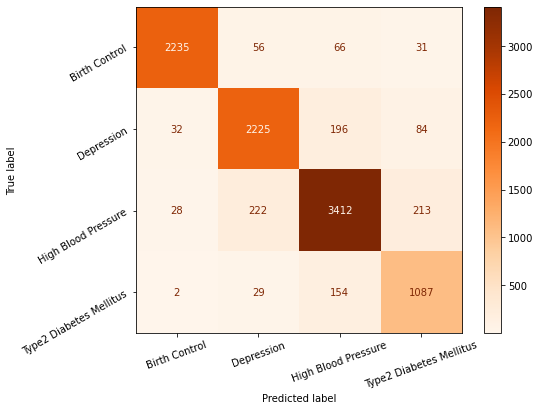

In [24]:
# Grid search
model = LogisticRegression(multi_class='ovr',
                           max_iter=1000,
                           class_weight=class_weights,
                           n_jobs=-1)

# defining grid parameters
grid_parameters = { 
                    'C'       :   np.logspace(-1, 2, 20),
                    'penalty' : ['l1','l2']
                  }
# calling gridsearch function

best_params,train_accuracy,y_predicted,accuracy_valid,cm = gridsearch(model,
                                                                      grid_parameters,
                                                                      StratifiedKFold(n_splits=3),
                                                                      count_train,
                                                                      y_train,
                                                                      count_test,
                                                                      y_test)
## Printing best parameters given by gridsearch 
print("Best parameters : ", best_params, " \n")

## printing train accuracy
print("Training Accuracy :   ", train_accuracy)

## printing train accuracy
print("Validation Accuracy :   ", accuracy_valid)
print("\n")
print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Oranges',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters :  {'C': 7.847599703514611, 'penalty': 'l2'}  

Training Accuracy :    0.8915061962067735
Validation Accuracy :    0.8991262907069102
Confusion Matrix: 
 [[2259   54   55   20]
 [  24 2276  176   61]
 [  40  213 3418  204]
 [   8   25  136 1103]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2388
           1       0.89      0.90      0.89      2537
           2       0.90      0.88      0.89      3875
           3       0.79      0.87      0.83      1272

    accuracy                           0.90     10072
   macro avg       0.89      0.90      0.89     10072
weighted avg       0.90      0.90      0.90     10072



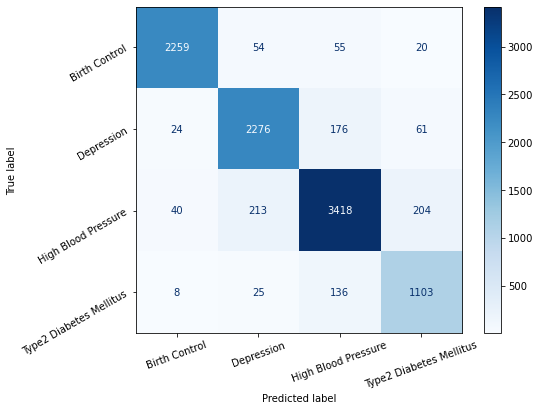

In [25]:
# tfidf vectors
best_params,train_accuracy,y_predicted,accuracy_valid,cm = gridsearch(model,
                                                                      grid_parameters,
                                                                      StratifiedKFold(n_splits=3),
                                                                      tfidf_train_ngram,
                                                                      y_train,
                                                                      tfidf_test_ngram,
                                                                      y_test)
## Printing best parameters given by gridsearch 
print("Best parameters : ", best_params, " \n")

## printing train accuracy
print("Training Accuracy :   ", train_accuracy)

## printing train accuracy
print("Validation Accuracy :   ", accuracy_valid)

print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

# SVC

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters :  {'C': 7.847599703514611, 'kernel': 'rbf'}  

Training Accuracy :    0.8736099942332972
Validation Accuracy :    0.8843328038125496


Confusion Matrix: 
 [[2231   64   77   16]
 [  63 2170  257   47]
 [  61  190 3474  150]
 [  16   38  186 1032]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      2388
           1       0.88      0.86      0.87      2537
           2       0.87      0.90      0.88      3875
           3       0.83      0.81      0.82      1272

    accuracy                           0.88     10072
   macro avg       0.88      0.87      0.88     10072
weighted avg       0.88      0.88      0.88     10072



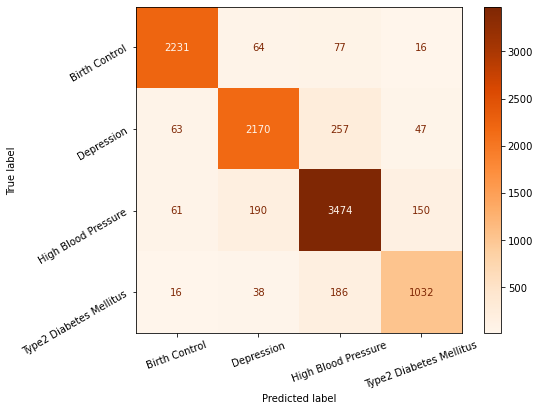

In [26]:
# Grid search
model = SVC( class_weight=class_weights,random_state=12)

# gridsearch parameters
grid_parameters = {  
                   'C'     :        np.logspace(-1,2,20), 
                   #'gamma' :        np.logspace(-5,5,10),
                   'kernel':        ['rbf','linear']
                  }

# calling gridsearch function
best_params,train_accuracy,y_predicted,accuracy_valid,cm = gridsearch(model,
                                                                      grid_parameters,
                                                                      StratifiedKFold(n_splits=3),
                                                                      count_train,
                                                                      y_train,
                                                                      count_test,
                                                                      y_test)
## Printing best parameters given by gridsearch 
print("Best parameters : ", best_params, " \n")

## printing train accuracy
print("Training Accuracy :   ", train_accuracy)

## printing train accuracy
print("Validation Accuracy :   ", accuracy_valid)
print("\n")
print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Oranges',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics. 
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters :  {'C': 1.8329807108324356, 'kernel': 'rbf'}  

Training Accuracy :    0.8984809272694033
Validation Accuracy :    0.9070691024622717


Confusion Matrix: 
 [[2231   61   88    8]
 [  24 2245  237   31]
 [  25  164 3599   87]
 [   4   30  177 1061]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      2388
           1       0.90      0.88      0.89      2537
           2       0.88      0.93      0.90      3875
           3       0.89      0.83      0.86      1272

    accuracy                           0.91     10072
   macro avg       0.91      0.90      0.90     10072
weighted avg       0.91      0.91      0.91     10072



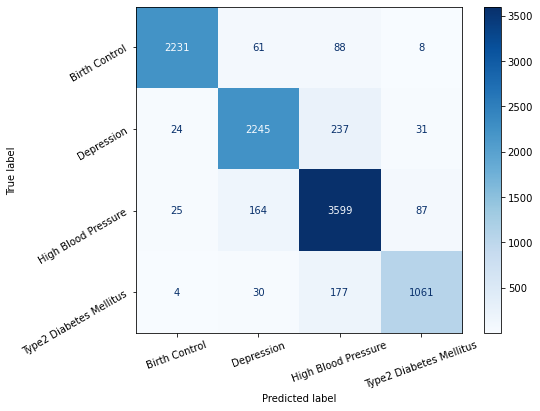

In [27]:
# Grid search
model = SVC(class_weight=class_weights,random_state=12)

# gridsearch parameters
grid_parameters = {  
                   'C'     :        np.logspace(-1,2,20), 
                   #'gamma' :        np.logspace(-5,5,10),
                   'kernel':        ['rbf','linear']
                    }

# calling gridsearch function 
best_params,train_accuracy,y_predicted,accuracy_valid,cm = gridsearch(model,
                                                                      grid_parameters,
                                                                      StratifiedKFold(n_splits=3),
                                                                      tfidf_train_ngram,
                                                                      y_train,
                                                                      tfidf_test_ngram,
                                                                      y_test)
## Printing best parameters given by gridsearch 
print("Best parameters : ", best_params, " \n")

## printing train accuracy
print("Training Accuracy :   ", train_accuracy)

## printing train accuracy
print("Validation Accuracy :   ", accuracy_valid)
print("\n")
print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

# RandomForest

Fitting 3 folds for each of 224 candidates, totalling 672 fits
Best parameters :  {'max_depth': 29, 'n_estimators': 140}  

Training Accuracy :    0.7681938993898969
Validation Accuracy :    0.7744241461477362


Confusion Matrix: 
 [[2080   33  275    0]
 [  19 1547  970    1]
 [   6   25 3842    2]
 [   5    7  929  331]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.87      0.92      2388
           1       0.96      0.61      0.75      2537
           2       0.64      0.99      0.78      3875
           3       0.99      0.26      0.41      1272

    accuracy                           0.77     10072
   macro avg       0.89      0.68      0.71     10072
weighted avg       0.85      0.77      0.76     10072



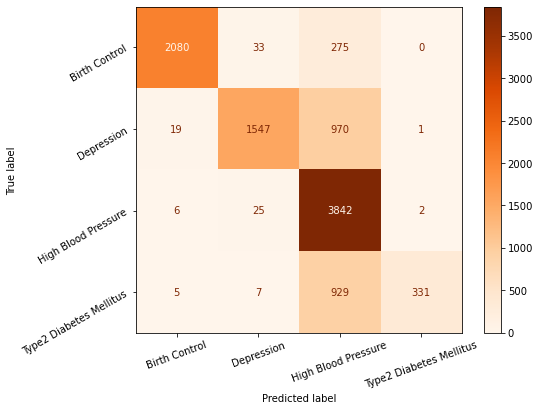

In [28]:
grid_parameters = { 
                    "n_estimators"     : [50,60,70,80,90,100,120,140],  
                    "max_depth"        : range(2,30,1)
              }


model = RandomForestClassifier(random_state = 1,n_jobs=-1)

# calling gridsearch function

best_params,train_accuracy,y_predicted,accuracy_valid,cm = gridsearch(model,
                                                                      grid_parameters,
                                                                      StratifiedKFold(n_splits=3),
                                                                      count_train,
                                                                      y_train,
                                                                      count_test,
                                                                      y_test)
## Printing best parameters given by gridsearch 
print("Best parameters : ", best_params, " \n")

## printing train accuracy
print("Training Accuracy :   ", train_accuracy)

## printing train accuracy
print("Validation Accuracy :   ", accuracy_valid)
print("\n")
print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Oranges',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))

Fitting 3 folds for each of 224 candidates, totalling 672 fits
Best parameters :  {'max_depth': 29, 'n_estimators': 90}  

Training Accuracy :    0.7876786828149132
Validation Accuracy :    0.7903097696584591


Confusion Matrix: 
 [[2081   35  272    0]
 [  37 1601  897    2]
 [  14   33 3816   12]
 [   5    6  799  462]]
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.87      0.92      2388
           1       0.96      0.63      0.76      2537
           2       0.66      0.98      0.79      3875
           3       0.97      0.36      0.53      1272

    accuracy                           0.79     10072
   macro avg       0.89      0.71      0.75     10072
weighted avg       0.85      0.79      0.78     10072



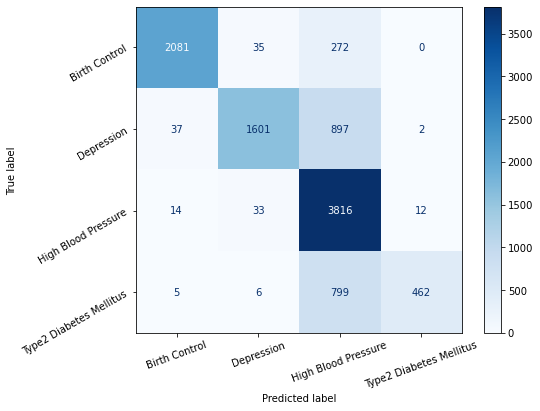

In [29]:
# calling gridsearch function on tf-didf vectors
best_params,train_accuracy,y_predicted,accuracy_valid,cm = gridsearch(model,
                                                                      grid_parameters,
                                                                      StratifiedKFold(n_splits=3),
                                                                      tfidf_train_ngram,
                                                                      y_train,
                                                                      tfidf_test_ngram,
                                                                      y_test)
## Printing best parameters given by gridsearch 
print("Best parameters : ", best_params, " \n")

## printing train accuracy
print("Training Accuracy :   ", train_accuracy)

## printing train accuracy
print("Validation Accuracy :   ", accuracy_valid)
print("\n")
print("Confusion Matrix: \n",cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',ax=ax)  
labels = ['Birth Control','Depression','High Blood Pressure','Type2 Diabetes Mellitus']
ax.xaxis.set_ticklabels(labels,rotation=20); ax.yaxis.set_ticklabels(labels,rotation=30);

 ## printing Classification Report: A text report showing the main classification metrics.
print(" ")
print("Classification Report : \n", classification_report(y_test, y_predicted))